In [94]:
import fcsfiles as fcs # Small one-man repo, likely has bugs
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import inspect

In [95]:
def fcs_extract(data, replicates=range(0,10)):
    times_counts = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CountRateArray'][:,0]
    times_corr = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CorrelationArray'][:,0]
    bins_hist = data['FcsData']['FcsEntry'][0]['FcsDataSet']["PhotonCountHistogramArray"][:,0]
    for i in replicates:
        tmp_bins_hist = data['FcsData']['FcsEntry'][i]['FcsDataSet']["PhotonCountHistogramArray"][:,0]
        if tmp_bins_hist.shape[0] > bins_hist.shape[0]:
            bins_hist = tmp_bins_hist
    all_counts = np.zeros((len(times_counts), len(replicates)))
    all_corr = np.zeros((len(times_corr), len(replicates)))
    sum_hist = np.zeros(len(bins_hist))
    for n, i in enumerate(replicates):
        all_counts[:,n] = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CountRateArray'][:,1]
        all_corr[:,n] = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
        vals_to_add = data['FcsData']['FcsEntry'][i]['FcsDataSet']['PhotonCountHistogramArray'][:,1]
        sum_hist[0:len(vals_to_add)] += vals_to_add
    mean_corr = np.mean(all_corr, axis=1)
    return times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist

In [96]:
data = fcs.ConfoCor3Fcs('../data/2024_09_05-FCSandImg/atto488_2nM_new.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)

In [97]:
def plot_fit(xdata, ydata, f, text="2nM atto488 at 0.2% laser power", bounds=(0,100)):
    fit = curve_fit(f, xdata, ydata, bounds=bounds)
    popt, pcov = fit
    perr = np.sqrt(np.diag(pcov))
    fig, axs = plt.subplots(2, 1, figsize=(8,8))
    axs[0].plot(xdata, f(xdata, *popt))
    axs[0].set_xscale("log")
    axs[0].plot(xdata, ydata, color="C03")
    axs[0].set_title(f"{text}")
    residuals = ydata - f(xdata, *popt)
    axs[1].plot(xdata, residuals, color="C03")
    axs[1].set_xscale("log")
    axs[1].set_title(f"Residuals")
    print(popt)

In [98]:
def f(tau, N, tauD, k):
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5

[2.21429813e+00 1.94842420e-04 4.16231119e+00]


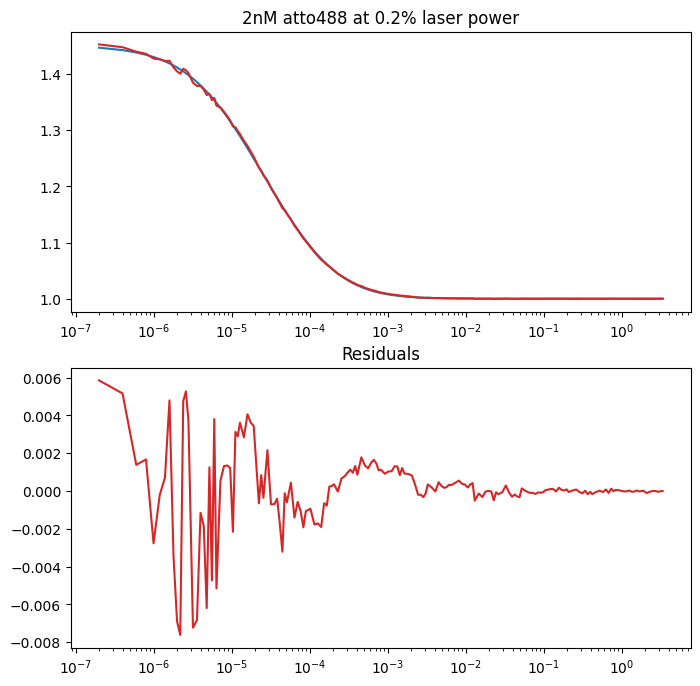

In [99]:
plot_fit(times_corr, mean_corr, f)

In [100]:
def fcs_fit_params(times_corr, mean_corr, func, conc):
    fit = curve_fit(func, times_corr, mean_corr, p0=None)
    popt, pcov = fit
    N, tauD, K = popt
    C = conc
    w3 = N/(C*np.pi**(3/2)*K)
    w_by_conc = w3**(1./3)
    w_by_diff = tauD*4*400
    return w_by_conc, w_by_diff, tauD, K, N

In [101]:
w_by_conc, w_by_diff, tauD, K, N = fcs_fit_params(times_corr, mean_corr, f, 2)
print(w_by_conc, w_by_diff, tauD, K, N)

0.362840529120613 0.31174728062139734 0.00019484205038837335 4.1623053651880175 2.2142982575413384


/tmp/ipykernel_117950/3600407703.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


In [117]:
data = fcs.ConfoCor3Fcs('../data/2024_09_05-FCSandImg/atto488_2nM_old_noBSA.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)
w_by_conc2, w_by_diff2, tauD2, K2, N2 = fcs_fit_params(times_corr, mean_corr, f, 2)
print(w_by_conc2, w_by_diff2, tauD2, K2, N2)

0.2957375341388303 0.3462159846262742 0.00021638499039142137 4.649064846796858 1.3391824548768743


/tmp/ipykernel_117950/3600407703.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


In [116]:
print("V =",N/2)
print("V =",np.pi**(3/2)*w_by_diff**(3)*K)
print("V =",N2/2)
print("V =",np.pi**(3/2)*w_by_diff2**(3)*K)
print("V =",np.pi**(3/2)*.3**(3)*K)

V = 1.1071491287706692
V = 0.7022096110078837
V = 0.6695912274384371
V = 0.9618339300683715
V = 0.62578120040116


In [93]:
data = fcs.ConfoCor3Fcs('../data/2024_09_05-FCSandImg/Ap4_1nuc_unpolarized.fcs')
times_corr = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CorrelationArray'][:,0]

In [83]:
def f_fit(tau, N, tauD):
    k = 4.1623
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5
def f_anomalous(tau, N, tauD):
    k = 4.1623
    alpha = 0.65
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5

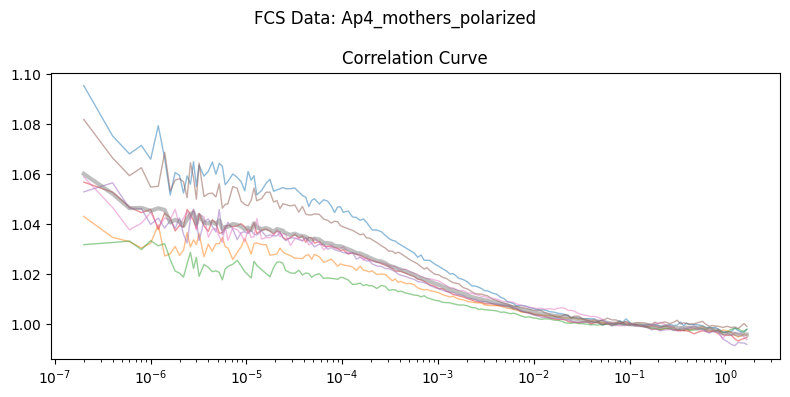

In [84]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
axs.set_xscale("log")
sum_corr = np.zeros(len(corr))
for i in range(7):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    corr = corr - corr[135] + 1
    axs.plot(times_corr, corr, linewidth=1, alpha=0.5)
    sum_corr += corr
avg_corr = sum_corr/7
axs.set_title("Correlation Curve")
axs.plot(times_corr, avg_corr, linewidth=3, alpha=0.5, color="grey")
fig.tight_layout()

[2.21719811e+01 8.46640795e-03]


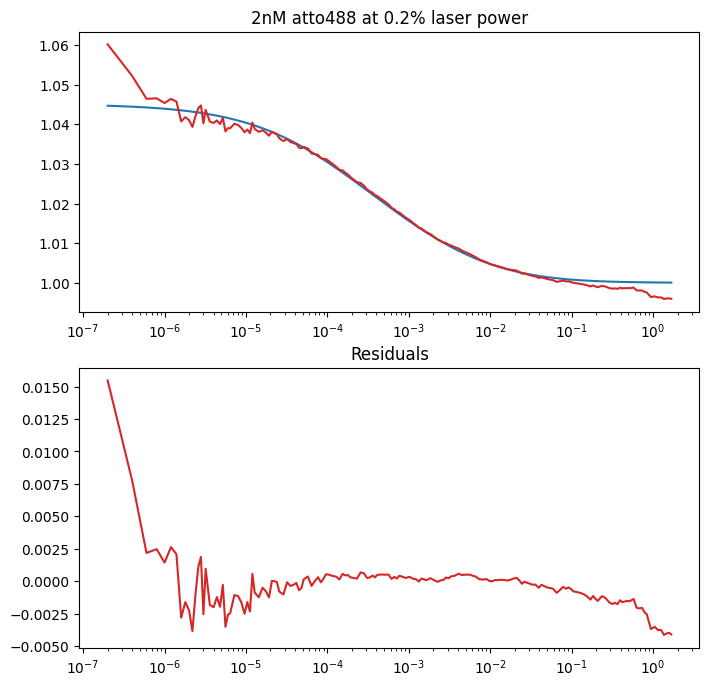

In [85]:
plot_fit(times_corr, avg_corr, f_anomalous)

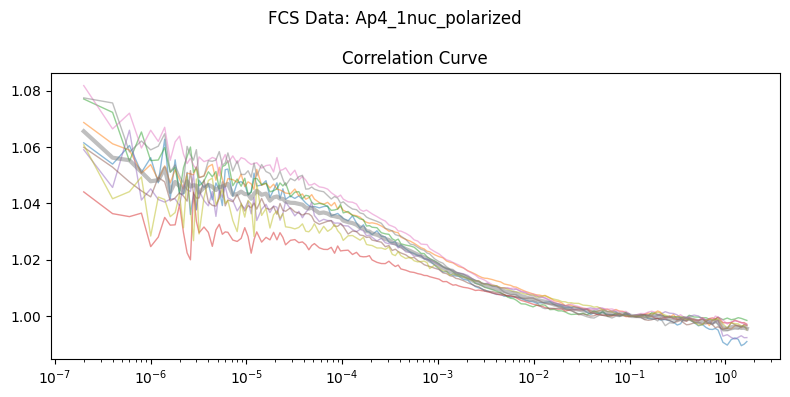

In [86]:
data = fcs.ConfoCor3Fcs('../data/2024_09_05-FCSandImg/Ap4_1nuc_polarized.fcs')
times_corr = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CorrelationArray'][:,0]
corr = data['FcsData']['FcsEntry'][4]['FcsDataSet']['CorrelationArray'][:,1]
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
axs.set_xscale("log")
sum_corr = np.zeros(len(corr))
n_samp = 9
for i in range(n_samp):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    corr = corr - corr[135] + 1
    axs.plot(times_corr, corr, linewidth=1, alpha=0.5)
    sum_corr += corr
avg_corr = sum_corr/n_samp
axs.set_title("Correlation Curve")
axs.plot(times_corr, avg_corr, linewidth=3, alpha=0.5, color="grey")
fig.tight_layout()

[2.00548587e+01 9.20284378e-03]


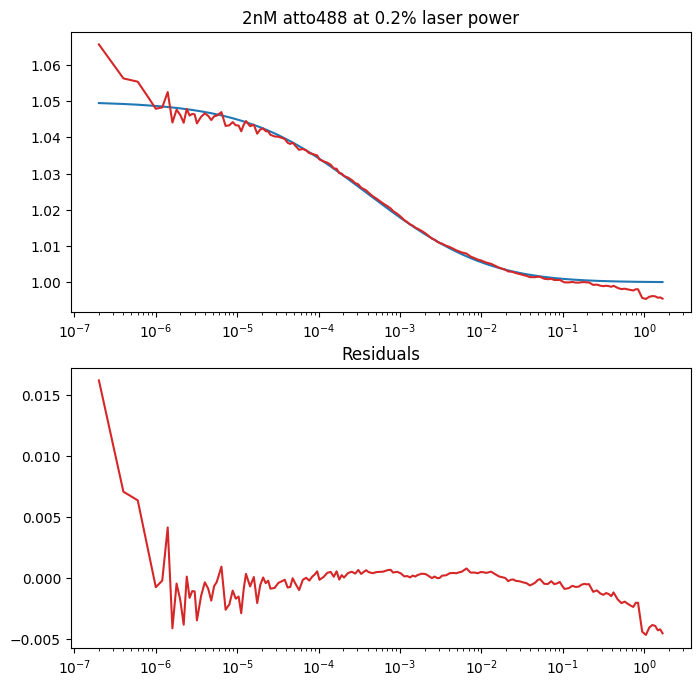

In [87]:
plot_fit(times_corr, avg_corr, f_anomalous)

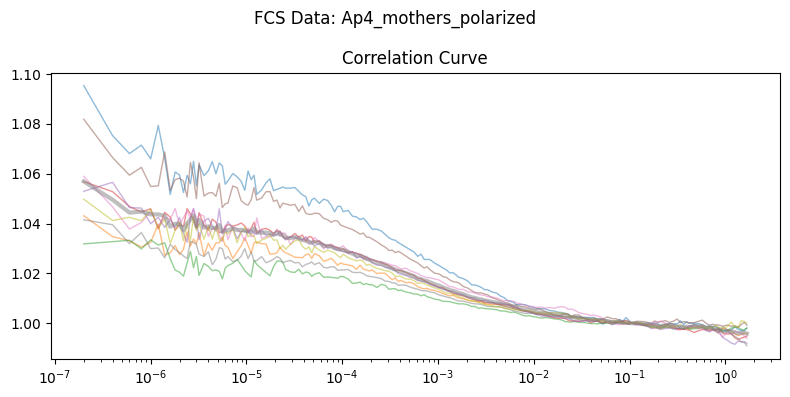

In [88]:
data = fcs.ConfoCor3Fcs('../data/2024_09_05-FCSandImg/Ap4_mothers_polarized.fcs')
times_corr = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CorrelationArray'][:,0]
corr = data['FcsData']['FcsEntry'][4]['FcsDataSet']['CorrelationArray'][:,1]
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
axs.set_xscale("log")
sum_corr = np.zeros(len(corr))
n_samp = 9
for i in range(n_samp):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    corr = corr - corr[135] + 1
    axs.plot(times_corr, corr, linewidth=1, alpha=0.5)
    sum_corr += corr
avg_corr = sum_corr/n_samp
axs.set_title("Correlation Curve")
axs.plot(times_corr, avg_corr, linewidth=3, alpha=0.5, color="grey")
fig.tight_layout()

[2.32790332e+01 8.48313469e-03]


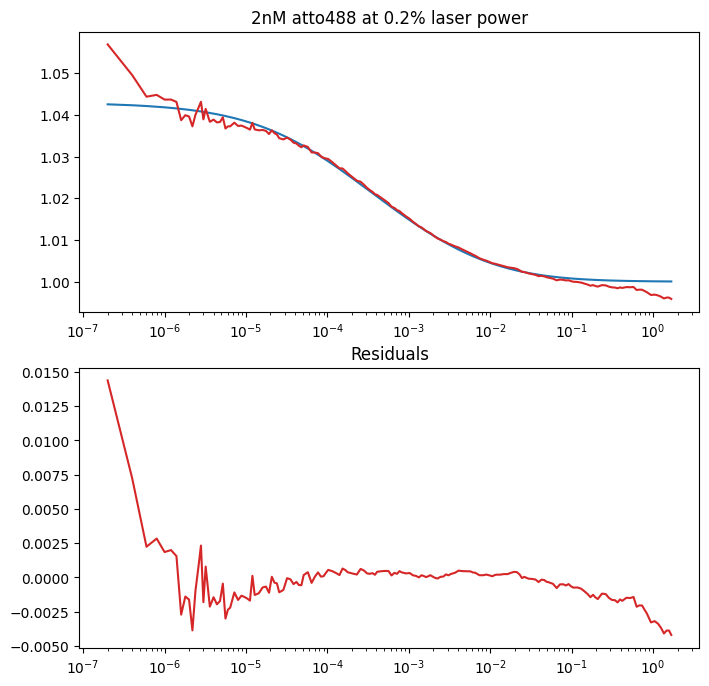

In [89]:
plot_fit(times_corr, avg_corr, f_anomalous)

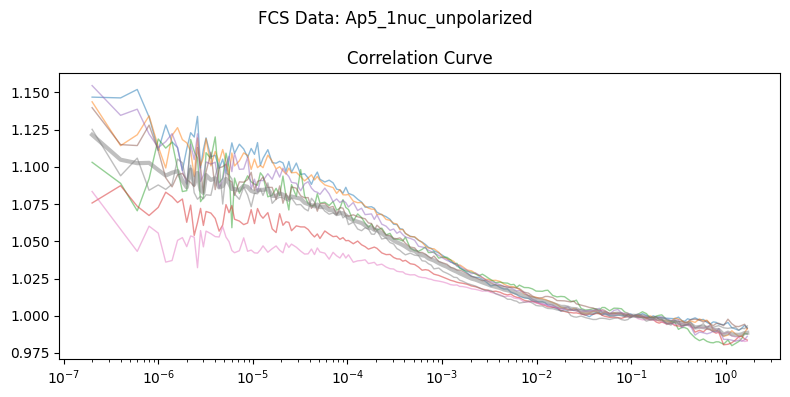

In [91]:
data = fcs.ConfoCor3Fcs('../data/2024_09_05-FCSandImg/Ap5_1nuc_unpolarized.fcs')
times_corr = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CorrelationArray'][:,0]
corr = data['FcsData']['FcsEntry'][4]['FcsDataSet']['CorrelationArray'][:,1]
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
axs.set_xscale("log")
sum_corr = np.zeros(len(corr))
n_samp = 8
for i in range(n_samp):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    corr = corr - corr[135] + 1
    axs.plot(times_corr, corr, linewidth=1, alpha=0.5)
    sum_corr += corr
avg_corr = sum_corr/n_samp
axs.set_title("Correlation Curve")
axs.plot(times_corr, avg_corr, linewidth=3, alpha=0.5, color="grey")
fig.tight_layout()

[1.02660124e+01 8.37688688e-03]


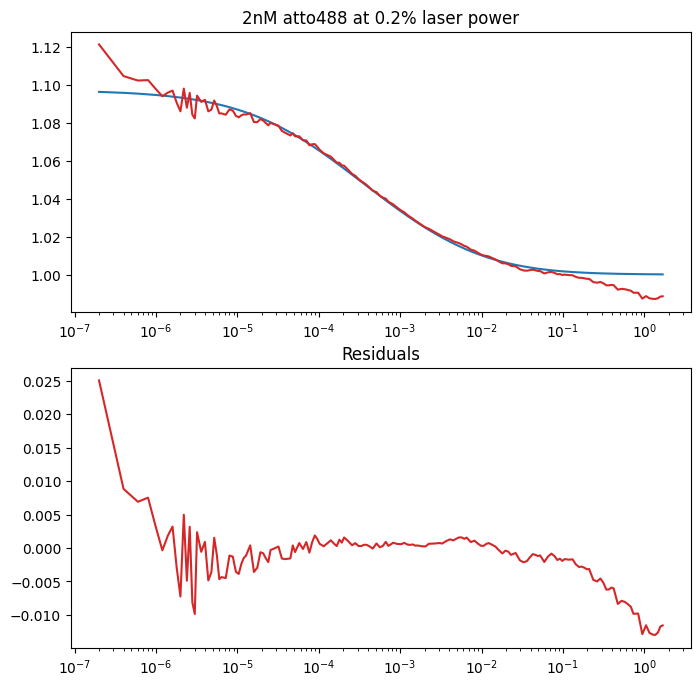

In [92]:
plot_fit(times_corr, avg_corr, f_anomalous)